<a href="https://colab.research.google.com/github/ashweta1/interp/blob/main/cs230_measuring_llm_factual_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Measuring Factual accuracy in LLMs using a known facts dataset

**Dataset** from https://github.com/kmeng01/rome/tree/main/dsets

**Model**: GPT2 (small)

**Metrics**:
*   **Exact match accuracy**: how often the model correctly predicts the next factual token given a prompt, greedily only considering the highest probability token.
*   **Probabalistic weighted accuracy**: Also consider non-top tokens weighing accuracy down acc to relative probabilty to top token.
*   **BLEU score**: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
*   **Perplexity** (expoentiated CE loss for predicting prompt+prediction - lower is better)

In [1]:
import os

IsLocal = True  ## Switch this to False if running on hosted colab runtime.
print("HOME = ", os.environ["HOME"])
if IsLocal:
  # Set a custom HOME directory
  os.environ["HOME"] = "/home/shweta/colab_home/cs230_llm_fact_accuracy"
  print("HOME is now set to:", os.environ["HOME"])
  os.chdir(os.environ["HOME"])
# Verify
!pwd

HOME =  /home/shweta
HOME is now set to: /home/shweta/colab_home/cs230_llm_fact_accuracy
/home/shweta/colab_home/cs230_llm_fact_accuracy


In [2]:
%%bash

# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# LOCAL=true ## change this to false to run on hosted runtime.

# CONTENT_HOME="/content/home"

# if $LOCAL; then
#   CONTENT_HOME="colab_home/cs230_llm_fact_accuracy"
# fi

# echo "Local = $LOCAL"
# echo "Content home = $CONTENT_HOME"

# cd   # go home
# pwd
# mkdir -p $CONTENT_HOME
# cd $CONTENT_HOME # Go home for this colab

# reclone and install rome.
pwd

pip install --upgrade pip setuptools wheel
rm -fr ./rome && git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
cd rome

# install needed packages.
pip install --upgrade google-cloud-storage >> install.log 2>&1
pip install datasets >> install.log 2>&1
pip intsall torch >> install.log 2>&1
pip install transformers >> install.log 2>&1
pip install evaluate >> install.log 2>&1
pip install nltk >> install.log 2>&1
pip install matplotlib >> install.log 2>&1
pip install ipywidgets --upgrade

pwd


/home/shweta/colab_home/cs230_llm_fact_accuracy
/home/shweta/colab_home/cs230_llm_fact_accuracy/rome


In [3]:
try:
    import google.colab, torch, os
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
    torch.set_grad_enabled(False)
except ModuleNotFoundError as _:
    pass

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Set parameters

MODEL_NAME = "gpt2"
# MODEL_NAME = "gpt2-medium"
# MODEL_NAME = "gpt2-large"
# MODEL_NAME = "gpt2-xl"

# NUM_BEAMS = 1
NUM_BEAMS = 3

CONTEXT = ""
# CONTEXT = "Answer as a precise fact. "
# CONTEXT = "Complete this sentence precisely based on facts. "

## Functions to generate predictions from the model and plot histograms.

In [6]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mt

def predict_probs_from_prompt(model, tokenizer, prompt, device="cuda"):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    # inp = make_inputs(tokenizer, [prompt])
    out = model(input_ids.to(device))
    out = out["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    # print(probs.shape)

    # get top 10 probabilities and predictions
    topk_probs, topk_indices = torch.topk(probs, k=10, dim=1)
    # print(topk_probs, topk_probs.shape)
    # print(topk_indices, topk_indices.shape)

    # create a list with tuples of token to probability
    result = [(tokenizer.decode(int(c)),float(p)) for p,c in zip(topk_probs[0], topk_indices[0])]
    return result

def generate_text(model, tokenizer, prompt, max_length=50, device="cuda"):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    outputs = model.generate(input_ids.to(device),
                             max_length=max_length,
                             do_sample=True,
                             num_beams=NUM_BEAMS,
                             temperature=0.7,
                             no_repeat_ngram_size=2,
                             early_stopping=True,
                             eos_token_id=tokenizer.encode(".")[0])

    # Decode the generated sequence back to text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text


def plot_word_probabilities(result):
    # Unpack the words and their probabilities
    words = [item[0] for item in result]
    probabilities = [item[1] for item in result]

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.bar(words, probabilities, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Probability')
    plt.title('Top 10 Word Probabilities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

## Functions to evaluate factual accuracy

In [7]:
import evaluate  # https://huggingface.co/spaces/evaluate-metric/perplexity
import nltk
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def prepare_prompt(prompt, prepend_context=""):
    return prepend_context + " " + prompt

# Function to remove only the initial overlapping prompt tokens
def remove_initial_overlap(tokens, prompt_tokens):
    i = 0
    while i < len(tokens) and i < len(prompt_tokens) and tokens[i] == prompt_tokens[i]:
        i += 1
    return tokens[i:]  # Return the tokens after the initial overlap

def clean_text(text):
    # Remove non-alphanumeric characters
    return re.sub(r'[^\w\s]', '', text).strip()

def get_question_answers_from_example(example, dataset_type):
    if dataset_type == "knowns":
        return example["prompt"], [example["prediction"]]
    elif dataset_type == "squad":
        return example["question"], example["answers"]["text"]
    elif dataset_type == "wikiqa":
        return example["question"], [example["answer"]]
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

def avg_prediction_accuracy(model,
                            tokenizer,
                            known_facts,
                            dataset_type="knowns",
                            context=CONTEXT,
                            debug=False,
                            max_examples=None):
    correct = 0
    total = 0
    for k in known_facts:
        debug and print("Fact: ", k)
        question, answers = get_question_answers_from_example(k, dataset_type)
        if len(answers) == 0:
            debug and print("No answers for question: ", question)
            continue
        answer = answers[0]

        prompt = prepare_prompt(question, context)
        expected_prediction = answer.split()[0]

        result = predict_probs_from_prompt(model, tokenizer, prompt)
        debug and print(result)
        debug and print("Prompt: ", prompt,
                        "expected prediction: ", expected_prediction,
                        "actual prediction: ", result[0][0])

        if result[0][0].strip() == expected_prediction.strip():
            correct += 1
        total += 1
        if max_examples is not None and total >= max_examples:
          break

    return correct / total

def weighted_prediction_accuracy(model,
                                 tokenizer,
                                 known_facts,
                                 dataset_type="knowns",
                                 context=CONTEXT,
                                 debug=False,
                                 max_examples=None):
    correct = 0
    total = 0
    for k in known_facts:
        question, answers = get_question_answers_from_example(k, dataset_type)
        if len(answers) == 0:
            debug and print("No answers for question: ", question)
            continue
        answer = answers[0]

        prompt = prepare_prompt(question, context)
        expected_prediction = answer.split()[0]
        result = predict_probs_from_prompt(model, tokenizer, prompt)
        debug and print("Prompt: ", prompt,
                        "expected prediction: ", expected_prediction,
                        "actual prediction: ", result[0][0])

        debug and print(result)
        max_prob = result[0][1]
        debug and print("Max prob = ", result[0][1])
        for r in result:
          if r[0].strip() == expected_prediction.strip():
            debug and r[1] < max_prob and print(f"Lower prob matching prediction: {r[0]} with relative probability {r[1]/max_prob}")
            correct += r[1]/max_prob
            break
        total += 1
        if max_examples is not None and total >= max_examples:
          break

    return correct / total

def avg_bleu_score(model,
                   tokenizer,
                   known_facts,
                   dataset_type="knowns",
                   context=CONTEXT,
                   debug=False,
                   device="cuda",
                   max_examples=None):
    sum_bleu = 0
    total = 0
    ignored = 0
    smoothing = SmoothingFunction()
    ngram_weights = [0.25, 0.25, 0.25, 0.25]
    for k in known_facts:
        question, answers = get_question_answers_from_example(k, dataset_type)
        debug and print("Question: ", question)
        debug and print("Answers: ", answers)
        if (len(answers) == 0):
          debug and print("Ignoring question with no answers: ", k)
          ignored += 1
          continue
        question = clean_text(prepare_prompt(question, context))
        answers = [clean_text(a) for a in answers]

        generated_text = generate_text(model, tokenizer, question, device=device)
        # remove the question prefix from the generated answer and then compare.
        generated_text = generated_text.replace(question, '')
        # replace special characters like ?,
        generated_text = clean_text(generated_text)
        generated_text = generated_text.replace('?', '')
        # remove leading and trailing spaces
        generated_text = generated_text.strip()


        # Calculate BLEU score
        try:
          # bleu = sentence_bleu(reference_tokens_list,
          #                     generated_tokens,
          #                     weights=ngram_weights,
          #                     smoothing_function=smoothing.method1)
          bleu = sentence_bleu(answers,
                               generated_text,
                               weights=ngram_weights,
                               smoothing_function=smoothing.method1)

          if debug:
            print(f"BLEU Score for prompt: '{question}'\n"
                  f"Answers: '{answers}'\n"
                  f"Generated: '{generated_text}'\n"
                  f"BLEU score: {bleu:.4f}\n")
          sum_bleu += bleu
          total += 1
        except KeyError as e:
          print("KeyError: ", e)

        if max_examples is not None and total >= max_examples:
          break

        # print every 100 examples
        if total % 100 == 0:
          print(f"Average Bleu score for {total} examples: ", sum_bleu/total)
          print(f"Total ignored = ", ignored)

    print(f"Average BLEU score over {total} facts: {sum_bleu / total:.4f}")
    print(f"Total examples processed: ", total)
    print(f"Total ignored: ", ignored)
    return sum_bleu / total

def avg_perplexity(model,
                   tokenizer,
                   known_facts,
                   dataset_type="knowns",
                   context=CONTEXT,
                   debug=False,
                   max_examples=None):
    loss = 0
    total = 0
    ignored = 0

    for k in known_facts:
        question, answers = get_question_answers_from_example(k, dataset_type)
        if len(answers) == 0:
            debug and print("No answers for question: ", question)
            ignored += 1
            continue
        answer = answers[0]

        prompt = prepare_prompt(question, context)
        prediction = answer
        debug and print("Prompt with prediction: ", prompt + " " + prediction)

        # inputs = make_inputs(tokenizer, [prompt + prediction])
        inputs = tokenizer(prompt + " " + prediction, return_tensors="pt").to(model.device)

        # Create a labels tensor where the prompt part is masked (set to -100)
        labels = inputs["input_ids"].clone()  # Clone the input_ids to make labels
        prompt_tokens = tokenizer.encode(prompt, add_special_tokens=False)
        prompt_length = len(prompt_tokens)
        labels[:, :prompt_length] = -100  # Mask the prompt tokens (set to -100)
        if debug:
          print("Prompt tokens: ", prompt_tokens)
          print("Labels: ", labels)

        with torch.no_grad():
          out = model(**inputs, labels=labels)
          if debug:
            print(f"Loss: {out['loss']}")
            print(f"Perplexity: {torch.exp(out['loss'])}")
          loss += out["loss"].item()
        total += 1
        if max_examples is not None and total >= max_examples:
          break

    avg_loss = loss / total
    avg_perplexity = torch.exp(torch.tensor(avg_loss))


    print(f"Avg loss: {avg_loss}")
    print(f"Avg Perplexity: {avg_perplexity}")
    print(f"Total examples processed: ", total)
    print(f"Total ignored: ", ignored)
    return avg_perplexity

def hf_perplexity(model,
                  tokenizer,
                  known_facts,
                  dataset_type="knowns",
                  context=CONTEXT,
                  debug=False,
                  max_examples=None):
  perplexity = evaluate.load("perplexity", module_type="metric")
  input_texts = []
  ignored = 0
  for k in known_facts:

    question, answers = get_question_answers_from_example(k, dataset_type)
    if len(answers) == 0:
        debug and print("No answers for question: ", question, " Ignoring example.")
        ignored += 1
        continue
    answer = answers[0]

    prompt = prepare_prompt(question, context)
    prediction = answer
    input_texts.append(prompt + prediction)
    if max_examples is not None and len(input_texts) >= max_examples:
      break

  results = perplexity.compute(model_id='gpt2',
                               add_start_token=False,
                               predictions=input_texts)
  print("Avg perplexity from HF: ", results["mean_perplexity"])
  print("Total examples processed: ", len(input_texts))
  print("Total ignored: ", ignored)
  return results["mean_perplexity"]

# def f1_score(prediction, ground_truths):
#     # Token overlap calculation
#     prediction_tokens = set(prediction.strip().split())
#     ground_truth_tokens = set(" ".join(ground_truths).split())
#     overlap = prediction_tokens & ground_truth_tokens
#     if not overlap:
#         return 0
#     precision = len(overlap) / len(prediction_tokens)
#     recall = len(overlap) / len(ground_truth_tokens)
#     return 2 * (precision * recall) / (precision + recall)

In [8]:
## Get the model
from transformers import GPT2Tokenizer, GPT2LMHeadModel

def get_gpt2_model(model_name):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id).to("cuda")
    return model, tokenizer

model, tokenizer = get_gpt2_model(MODEL_NAME)

In [9]:
# Test a few prompts for generate_text
print(generate_text(model, tokenizer, "Michael Jordan plays the sport of"))
print(generate_text(model, tokenizer, "David Beckham plays the sport of soccer. Michael Jordan plays the sport of"))

Michael Jordan plays the sport of football for the University of Texas at Austin.
David Beckham plays the sport of soccer. Michael Jordan plays the sport of basketball.


[(' basketball', 0.13530074059963226), (' football', 0.08588828891515732), (' golf', 0.05622902140021324), (' hockey', 0.03582488000392914), (' rugby', 0.027497662231326103), (' soccer', 0.027262864634394646), (' baseball', 0.026173271238803864), (' tennis', 0.02406490035355091), (' boxing', 0.018518326804041862), (' wrestling', 0.014670118689537048)]


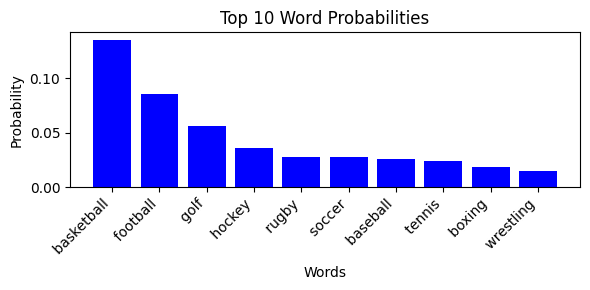

[(' basketball', 0.45353958010673523), (' football', 0.11771950870752335), (' soccer', 0.07294050604104996), (' golf', 0.05864378809928894), (' baseball', 0.03721913695335388), (' hockey', 0.03530564531683922), (' tennis', 0.02503659948706627), (' sports', 0.014940914697945118), (' boxing', 0.011122136376798153), (' rugby', 0.008775808848440647)]


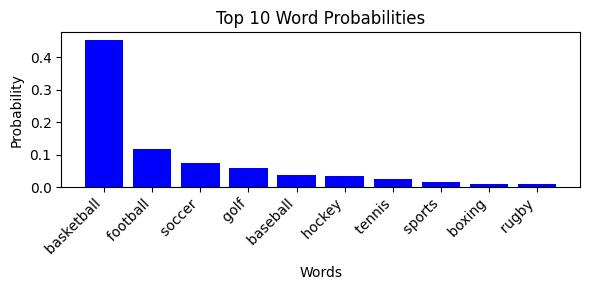

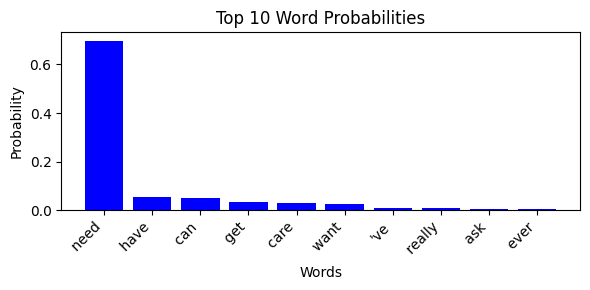

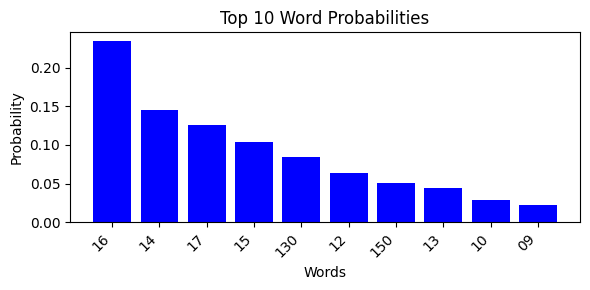

In [10]:
# Test a few probability histogram generation
result = predict_probs_from_prompt(model, tokenizer, "Michael Jordan plays the sport of")  # basketball
print(result)
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "David Beckham plays the sport of soccer. Michael Jordan plays the sport of")  # basketball
print(result)
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "The first prominent paper on transformers and attention was 'Attention is all you") # need
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "The url to 'Attention is all you need' paper is http://https://arxiv.org/abs/") # 1706.03762
plot_word_probabilities(result)

## Known facts dataset

In [11]:
!pip install --upgrade scipy
!pip install --upgrade scikit-learn

In [12]:
## Measure the factual accuracy on a dataset
# Using ROME's facts dataset
import os, re, json
os.chdir(os.environ['HOME'])
!pwd
os.chdir("rome")
!pwd
from util.globals import DATA_DIR
from dsets import KnownsDataset
knowns = KnownsDataset(DATA_DIR)

/home/shweta/colab_home/cs230_llm_fact_accuracy
/home/shweta/colab_home/cs230_llm_fact_accuracy/rome
data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|█████████████████████████████████████| 335k/335k [00:00<00:00, 495kB/s]

Loaded dataset with 1209 elements


In [13]:
# Debug mode
%env CUDA_LAUNCH_BLOCKING=1
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)
print("=======================================")

accuracy = avg_prediction_accuracy(model, tokenizer, knowns, debug=True, max_examples=5)
print(f"Avg Accuracy: {accuracy * 100:.2f}%")
print("=======================================")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, knowns, debug=True, max_examples=5)
print(f"Weighted Accuracy: {weighted_accuracy * 100:.2f}%")
print("=======================================")

bleu_score = avg_bleu_score(model, tokenizer, knowns, debug=True, max_examples=5)
print(f"Bleu score: {bleu_score:.4f}")
print("=======================================")

perplexity = avg_perplexity(model, tokenizer, knowns, debug=True, max_examples=5)
print(f"Perplexity: {perplexity:.4f}")
print("=======================================")

h_perplexity = hf_perplexity(model, tokenizer, knowns, debug=True, max_examples=5)
print(f"HF Perplexity: {h_perplexity:.4f}")
print("=======================================")

env: CUDA_LAUNCH_BLOCKING=1
MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Fact:  {'known_id': 0, 'subject': 'Vinson Massif', 'attribute': 'Antarctica', 'template': '{} is located in the continent', 'prediction': ' of Antarctica. It is the largest of the three', 'prompt': 'Vinson Massif is located in the continent of', 'relation_id': 'P30'}
[(' Africa', 0.0566563680768013), (' the', 0.038083747029304504), (' North', 0.03154773637652397), (' Europe', 0.02881760708987713), (' South', 0.026606017723679543), (' Antarctica', 0.01660737209022045), (' France', 0.01256568357348442), (' Italy', 0.01016746461391449), (' Madagascar', 0.009260972030460835), (' Mars', 0.009088225662708282)]
Prompt:   Vinson Massif is located in the continent of expected prediction:  of actual prediction:   Africa
Fact:  {'known_id': 1, 'subject': 'Beats Music', 'attribute': 'Apple', 'template': '{} is owned by', 'prediction': ' Apple, which is also the owner of Beats Electronics', 'prompt': 'Beats Music is owned b

  0%|          | 0/1 [00:00<?, ?it/s]

Avg perplexity from HF:  22.681014251708984
Total examples processed:  5
Total ignored:  0
HF Perplexity: 22.6810


In [14]:
# Full metrics

# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("Evaluating facts accuracy for Known facts dataset of 1000 records.")
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)

accuracy = avg_prediction_accuracy(model, tokenizer, knowns)
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, knowns)
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")

# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, knowns)
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, knowns)
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, knowns)
print(f"HF Perplexity: {h_perplexity:.4f}")


Evaluating facts accuracy for Known facts dataset of 1000 records.
MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Avg Factual Accuracy: 7.03%
Weighted Factual Accuracy: 13.44%
Average Bleu score for 100 examples:  0.28010894209861054
Total ignored =  0
Average Bleu score for 200 examples:  0.2713544687342787
Total ignored =  0
Average Bleu score for 300 examples:  0.26942914994902356
Total ignored =  0
Average Bleu score for 400 examples:  0.2704868210904392
Total ignored =  0
Average Bleu score for 500 examples:  0.2731521064406621
Total ignored =  0
Average Bleu score for 600 examples:  0.27287376390973134
Total ignored =  0
Average Bleu score for 700 examples:  0.2731522827142146
Total ignored =  0
Average Bleu score for 800 examples:  0.26880960137235194
Total ignored =  0
Average Bleu score for 900 examples:  0.26705796990982644
Total ignored =  0
Average Bleu score for 1000 examples:  0.26633427523985326
Total ignored =  0
Average Bleu score for 1100 examples:  0.267089862711593

  0%|          | 0/76 [00:00<?, ?it/s]

Avg perplexity from HF:  34.30073735021776
Total examples processed:  1209
Total ignored:  0
HF Perplexity: 34.3007


## SQuAD dataset

In [15]:
from datasets import load_dataset
squad = load_dataset("squad_v2")
# train_data = squad['train']
squad_val = squad['validation']
print(squad_val)

for example in squad_val:
  print(example)
  break
example = squad_val[0]
print("Context:", example['context'])
print("Question:", example['question'])
print("Answer:", example['answers']['text'])

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})
{'id': '56ddde6b9a695914005b9628', 'title': 'Normans', 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'question': 'In what country is Normandy located?', 'answers': {'text': ['France', 'France

In [16]:
# Debug mode.

# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)

accuracy = avg_prediction_accuracy(model, tokenizer, squad_val, dataset_type="squad", debug=True, max_examples=5)
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, squad_val, dataset_type="squad", debug=True, max_examples=5)
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")

# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, squad_val, dataset_type="squad", debug=True, max_examples=5)
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, squad_val, dataset_type="squad", debug=True, max_examples=5)
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, squad_val, dataset_type="squad", debug=True, max_examples=5)
print(f"HF Perplexity: {h_perplexity:.4f}")



MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Fact:  {'id': '56ddde6b9a695914005b9628', 'title': 'Normans', 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'question': 'In what country is Normandy located?', 'answers': {'text': ['France', 'France', 'France', 'France'], 'answer_start': [15

  0%|          | 0/1 [00:00<?, ?it/s]

Avg perplexity from HF:  262.00742492675784
Total examples processed:  5
Total ignored:  0
HF Perplexity: 262.0074


In [17]:
# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)

accuracy = avg_prediction_accuracy(model, tokenizer, squad_val, dataset_type="squad")
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, squad_val, dataset_type="squad")
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")


MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Avg Factual Accuracy: 0.00%
Weighted Factual Accuracy: 0.26%


In [18]:
# Full metrics
# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, squad_val, dataset_type="squad")
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, squad_val, dataset_type="squad")
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, squad_val, dataset_type="squad")
print(f"HF Perplexity: {h_perplexity:.4f}")


Average Bleu score for 100 examples:  0.08907357229779049
Total ignored =  117
Average Bleu score for 200 examples:  0.13193240968668005
Total ignored =  227
Average Bleu score for 300 examples:  0.1311509502923178
Total ignored =  336
Average Bleu score for 400 examples:  0.12393780055545572
Total ignored =  415
Average Bleu score for 500 examples:  0.11809913016806377
Total ignored =  502
Average Bleu score for 600 examples:  0.11893987214369228
Total ignored =  593
Average Bleu score for 700 examples:  0.11581238585758365
Total ignored =  692
Average Bleu score for 800 examples:  0.11807057700168704
Total ignored =  792
Average Bleu score for 900 examples:  0.11832726910939283
Total ignored =  886
Average Bleu score for 1000 examples:  0.11631359960959256
Total ignored =  993
Average Bleu score for 1100 examples:  0.11479165852742038
Total ignored =  1098
Average Bleu score for 1200 examples:  0.1168095131732834
Total ignored =  1167
Average Bleu score for 1300 examples:  0.11945119

  0%|          | 0/371 [00:00<?, ?it/s]

Avg perplexity from HF:  373.2371345131021
Total examples processed:  5928
Total ignored:  5945
HF Perplexity: 373.2371


## WikiQA dataset

In [19]:
from datasets import load_dataset

wikiqa_val = load_dataset("wiki_qa", split="validation")
print(wikiqa_val)

total_true = 0
for example in wikiqa_val:
  if example['label'] == 1:
    total_true += 1
print(f"Total true = {total_true}")

# Only keep the true examples
wikiqa_val = [example for example in wikiqa_val if example['label'] == 1]
print(len(wikiqa_val))

for example in wikiqa_val:
    print(example)
    break

example = wikiqa_val[0]
print("Question:", example['question'])
print("Answer:", example['answer'])

Dataset({
    features: ['question_id', 'question', 'document_title', 'answer', 'label'],
    num_rows: 2733
})
Total true = 140
140
{'question_id': 'Q11', 'question': 'how big is bmc software in houston, tx', 'document_title': 'BMC Software', 'answer': 'Employing over 6,000, BMC is often credited with pioneering the BSM concept as a way to help better align IT operations with business needs.', 'label': 1}
Question: how big is bmc software in houston, tx
Answer: Employing over 6,000, BMC is often credited with pioneering the BSM concept as a way to help better align IT operations with business needs.


In [20]:
# Debug mode.

# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)
DATASET_TYPE = "wikiqa"

accuracy = avg_prediction_accuracy(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE, debug=True, max_examples=5)
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE, debug=True, max_examples=5)
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")

# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE, debug=True, max_examples=10)
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE, debug=True, max_examples=5)
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE, debug=True, max_examples=5)
print(f"HF Perplexity: {h_perplexity:.4f}")


MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Fact:  {'question_id': 'Q11', 'question': 'how big is bmc software in houston, tx', 'document_title': 'BMC Software', 'answer': 'Employing over 6,000, BMC is often credited with pioneering the BSM concept as a way to help better align IT operations with business needs.', 'label': 1}
[('.', 0.09648309648036957), (',', 0.0607161819934845), ('?', 0.04504579305648804), ('n', 0.02804478257894516), (' is', 0.027810832485556602), (' and', 0.022862782701849937), (':', 0.01836109347641468), ('ns', 0.016324715688824654), ('s', 0.013028311543166637), ('l', 0.011085026897490025)]
Prompt:   how big is bmc software in houston, tx expected prediction:  Employing actual prediction:  .
Fact:  {'question_id': 'Q11', 'question': 'how big is bmc software in houston, tx', 'document_title': 'BMC Software', 'answer': 'For 2011, the company recorded an annual revenue of $2.1 billion, making it the #20 largest software company in terms of revenue for that year.',

  0%|          | 0/1 [00:00<?, ?it/s]

Avg perplexity from HF:  86.01304092407227
Total examples processed:  5
Total ignored:  0
HF Perplexity: 86.0130


In [21]:
# Full metrics.
# %env CUDA_LAUNCH_BLOCKING=1

# tokenizer.pad_token = tokenizer.eos_token
# model.config.pad_token_id = tokenizer.pad_token_id
# print(f"EOS Token ID: {tokenizer.eos_token_id}")
# print(f"PAD Token ID: {tokenizer.pad_token_id}")

# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)
DATASET_TYPE = "wikiqa"

accuracy = avg_prediction_accuracy(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE)
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE)
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")

# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE)
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE)
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, wikiqa_val, dataset_type=DATASET_TYPE)
print(f"HF Perplexity: {h_perplexity:.4f}")

MODEL_NAME =  gpt2  NUM_BEAMS =  3  CONTEXT =  
Avg Factual Accuracy: 0.00%
Weighted Factual Accuracy: 0.89%
Average Bleu score for 100 examples:  0.1401836409143837
Total ignored =  0
Average BLEU score over 140 facts: 0.1393
Total examples processed:  140
Total ignored:  0
Average Bleu score: 0.1393
Avg loss: 3.6421830705233984
Avg Perplexity: 38.17508316040039
Total examples processed:  140
Total ignored:  0
Avg Perplexity: 38.1751


  0%|          | 0/9 [00:00<?, ?it/s]

Avg perplexity from HF:  98.82172905036381
Total examples processed:  140
Total ignored:  0
HF Perplexity: 98.8217
